In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms as T

sys.path.append("../src")

from xraygen.models.classifier import XRayClassifier
from xraygen.explain.gradcam import GradCAM

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = XRayClassifier(num_classes=2).to(device)

# Path to your trained classifier weights
ckpt_path = "../models/classifier/model.pt"

if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded from:", ckpt_path)

Using device: cuda
Model loaded from: ../models/classifier/model.pt


In [3]:
#OPTION A: LOAD MANUALLY FROM IMAGE

img_root = "../data/raw"
img_name = "sample1.png"
img_path = os.path.join(img_root, img_name)

if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")

print("Using image:", img_path)

# Transform must match training
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),   # grayscale -> [1, H, W]
])

pil_img = Image.open(img_path).convert("L")
input_tensor = transform(pil_img).unsqueeze(0).to(device) #[1, 1, 256, 256]
print("Input tensor shape:", input_tensor.shape)

Using image: ../data/raw/sample1.png
Input tensor shape: torch.Size([1, 1, 256, 256])


In [4]:
#OPTION B: READ FROM CSV

import pandas as pd

csv_path = "../data/raw/metadata_sample.csv"
df = pd.read_csv(csv_path)
print(df.head())

row = df.iloc[0] #first row
img_name = row["filename"]
label = row["has_contraband"]
img_path = os.path.join(img_root, img_name)
print("Using image:", img_path, "| label:", label)

pil_img = Image.open(img_path).convert("L")
input_tensor = transform(pil_img).unsqueeze(0).to(device)

      filename  has_contraband
0  sample1.png               0
1  sample8.png               1
2  sample2.png               0
Using image: ../data/raw/sample1.png | label: 0


In [5]:
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.softmax(logits, dim=1)
    pred_class = probs.argmax(dim=1).item()
    print("Predicted class:", pred_class)
    print("Probabilities:", probs.cpu().numpy())

Predicted class: 1
Probabilities: [[0.20691057 0.7930894 ]]


In [ ]:
# explain the prediction using the last conv layer (conv2 in your model)
target_layer = model.conv2

gradcam = GradCAM(model, target_layer=target_layer)

# target_class=None -> uses argmax
cam = gradcam(input_tensor, target_class=None)

print("CAM shape:", cam.shape, "min:", cam.min(), "max:", cam.max())

CAM shape: (256, 256) min: 0.0 max: 0.0


/home/ssy/Desktop/xray-gen-ai_Project/xray-gen-ai/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


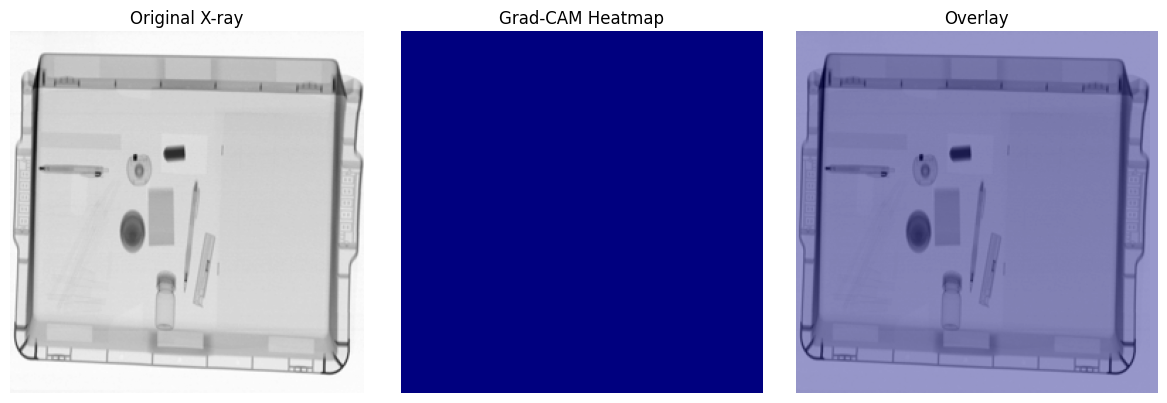

In [7]:
#convert original PIL image to numpy for plotting
orig = pil_img.resize((250, 256))
orig_np = np.array(orig)

plt.figure(figsize=(12,4))

#Original
plt.subplot(1,3,1)
plt.imshow(orig_np, cmap="gray")
plt.title("Original X-ray")
plt.axis("off")

#Heatmap only
plt.subplot(1,3,2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

#Overlay
plt.subplot(1,3,3)
plt.imshow(orig_np, cmap="gray")
plt.imshow(cam, cmap="jet", alpha=0.4) #alpha control blending
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
